In [1]:
from biodatatools.utils.common import json_load
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import sys

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Different tissues

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [6]:
# Only keep samples highlighted in Fig.2A

inputfile = f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt"
samples = list(pd.read_table(inputfile, header=None)[0])

In [7]:
ks = ["pl", "mn"]
bws = {}
for s in samples:
	bws[s] = [f"{PROJECT_DIR_o}rpm/{s}_{k}_rpm.bw" for k in ks]

In [8]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")

In [66]:
def browser_shots(dfs, regions, colors, ncols, samples_dict, figsize, outputfile, ylims=None, show_number=True, yspace=-0.3, xtick_pos="bottom"):
	fig, axes = plt.subplots(len(samples_dict), ncols, figsize=figsize)
	for r in dfs:
		chrom = r.split("_")[0]
		col = list(dfs.keys()).index(r)
		df = dfs[r]
		# 0-based
		start, end = min(df["position"]), max(df["position"])
		ymin, ymax = min(df[df["orientation"]=="rev"]["rpm"]), max(df[df["orientation"]=="fwd"]["rpm"])

		ks = ["fwd", "rev"]
		strand_colors = ["red", "blue"]
		for g in samples_dict:
			row = list(samples_dict).index(g)
			ax = axes[row, col]
			for k in ks:
				df2 = df[(df["type"]==g) & (df["orientation"]==k)]
				ax.bar(list(df2["position"]), list(df2["rpm"]), color=strand_colors[ks.index(k)], align="center", width=2)
	
			ax.ticklabel_format(useOffset=False, style="plain")
			start2 = int(start + 0.08*(end-start))
			end2 = int(end - 0.08*(end-start))
			ax.set_xticks([start2, end2])
			if xtick_pos == "top":
				ax.xaxis.tick_top()
				ax.set_xlabel("")
				if row != 0:
					ax.set_xticklabels([])
				else:
					ax.set_xticklabels([start2+1, end2+1])
					ax.set_title(chrom, fontsize=sfontsize)
			else:
				if row != len(samples_dict)-1:
					ax.set_xlabel("")
					ax.set_xticklabels([])
				else:
					ax.set_xlabel(chrom, fontsize=sfontsize)
					ax.set_xticklabels([start2+1, end2+1])

			if col == 0:
				ylabel = f"{g}\n(n={len(samples_dict[g])})" if show_number else g
				ax.set_ylabel(ylabel, 
							  rotation=0, ha="right", va="center",
							  fontsize=sfontsize, color=colors[row])
				ax.yaxis.set_label_coords(yspace, 0.5)
			else:
				ax.set_ylabel("")
			if ylims:
				ax.set_ylim(ylims[col])
			
			ax.tick_params(axis="x", labelsize=8)
			ax.tick_params(axis="y", labelsize=sfontsize)
			
		fig.subplots_adjust(hspace=0.4, wspace=0.5)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True)

In [11]:
# Get samples for each tissue type

samples_dict = defaultdict(list)
for t in cdict:
	samples_dict[t] = [s for s in samples if labels[s][1]==t]

In [12]:
colors = [cdict[t] for t in samples_dict]

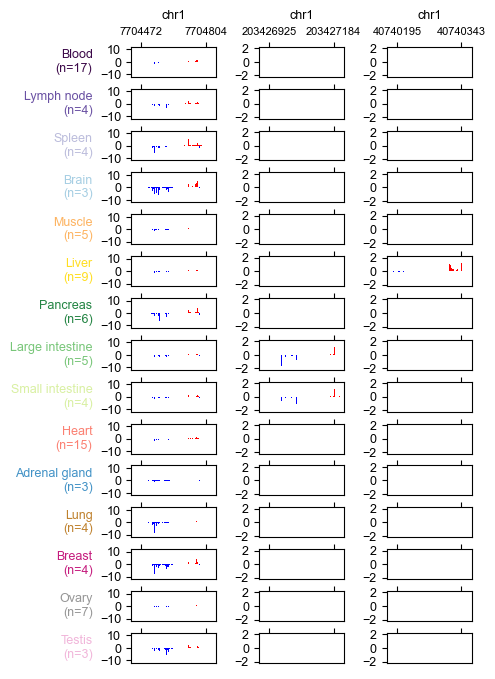

In [67]:
regions = [ # Example 1 
			"chr1_7704440_7704835",
			# Example 2
			"chr1_203426900_203427208",
			# Example 3
			"chr1_40740180_40740357"
		   ]
dfs = {}
for r in regions:
	dfs[r] = utils.get_reads(r, bws, samples_dict)
ylims = [[-12,12], [-2.2,2.2], [-2.2,2.2]]
outputfile = f"{PROJECT_DIR_o2}figures/Fig2b_top.png"
browser_shots(dfs, regions, colors, len(regions), samples_dict, (4.4,8), outputfile, ylims, True, -0.45, "top")

# Different subregions of the same tissue

In [57]:
ss = ["GT25", "EN24", "HN10"]
samples_dict2 = {}
for s in ss:
	if labels[s][0] == "Mucosa of descending colon":
		s2 = "Descending\ncolon"  
	elif labels[s][0] == "Transverse colon":
		s2 = "Transverse\ncolon"  
	else:
		s2 = labels[s][0]
	samples_dict2[s2] = [s]

In [58]:
colors2 = [cdict["Large intestine"]]*len(samples_dict2)

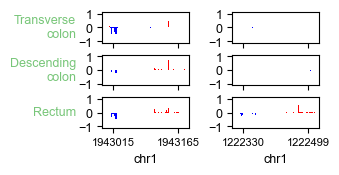

In [68]:
regions = [ # Example 1 
			"chr1_1943000_1943179",
			# Example 2
			"chr1_1222313_1222515"
		   ]
dfs = {}
for r in regions:
	dfs[r] = utils.get_reads(r, bws, samples_dict2)
ylims = [[-1.1,1.1]]*2
outputfile = f"{PROJECT_DIR_o2}figures/Fig2b_bottom.png"
browser_shots(dfs, regions, colors2, len(regions), samples_dict2, (2.8,1.5), outputfile, ylims, False)